# Import Libraries

In [1]:
# Importando bibliotecas utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Dataset

In [2]:
# Importação dos datasets necessários
raw_details_df = pd.read_csv('https://raw.githubusercontent.com/carneiroRomulo/SeazoneChallenge/main/datasets/details.csv')
raw_priceav_df = pd.read_csv('https://raw.githubusercontent.com/carneiroRomulo/SeazoneChallenge/main/datasets/priceav.csv')

# Data Cleaning


In [3]:
# Remove features desnecessárias para análise
raw_details_df = raw_details_df.drop(columns=['Unnamed: 0', 'ad_name'])
raw_priceav_df = raw_priceav_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [4]:
# Droping data que possui quantidade insignificante de missing values
df1_details = raw_details_df.dropna(subset=['number_of_bathrooms', 'number_of_reviews','number_of_bedrooms'])

In [5]:
# Completando missing values que são muito importantes para serem eliminados, preenchendo-os com a mediana entre eles
df2_details = df1_details.fillna(df1_details['star_rating'].median())

In [6]:
# Removendo outliers
df2_details = df2_details[(df2_details.number_of_bedrooms<4) & (df2_details.number_of_bathrooms<4)]

In [7]:
# Ignorando o valor do tempo presente em 'booked_on'
df1_price = raw_priceav_df
df1_price['booked_on'] = df1_price['booked_on'].apply(lambda x: x.split(' ')[0])

# 1. Ordene os bairros em ordem crescente de número de listings.

In [8]:
# Ordena os dataset em ordem ascendente de acordo com o número de listings em cada suburb
df3_details = df2_details.groupby('suburb', as_index=False).airbnb_listing_id.count()
df3_details.sort_values(['airbnb_listing_id'], inplace=True)

Text(0, 0.5, 'Number of Listings')

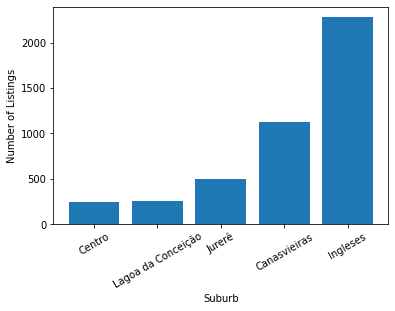

In [9]:
# Plotando gráfico para melhor visualização
plt.bar(df3_details.suburb, df3_details.airbnb_listing_id)
plt.xlabel('Suburb')
plt.xticks(rotation=30)
plt.ylabel('Number of Listings')

# 2. Ordene os bairros em ordem crescente de faturamento médio dos listings.

In [10]:
# Seleciona apenas os IDs ocupados
df2_price = df1_price.get(df1_price['occupied']==1)

In [11]:
# Combina os datasets
df_merged = pd.merge(df2_details, df2_price, how='inner')
df_merged.rename(columns={'price_string':'billing'}, inplace=True)

In [12]:
# Calcula a média de faturamento dos anúncios por bairro
df2_merged = df_merged.groupby('suburb', as_index=False).billing.mean().round(2)
df2_merged.sort_values(['billing'], inplace=True)

Text(0, 0.5, 'Billing')

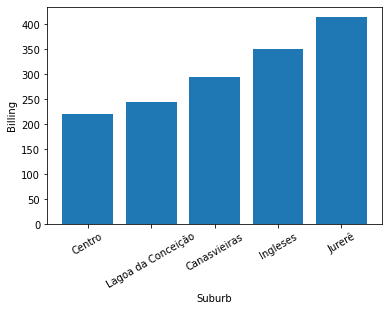

In [13]:
plt.bar(df2_merged.suburb, df2_merged.billing)
plt.xlabel('Suburb')
plt.xticks(rotation=30)
plt.ylabel('Billing')

# 3. Existem correlações entre as características de um anúncio e seu faturamento? Quais? Explique.

In [14]:
# Transforma variáveis categóricas em numérica
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

X = encoder.fit_transform(df_merged.suburb.values.reshape(-1,1)).toarray()

suburb_encoded = pd.DataFrame(X, columns = ['Jurerê', 'Canasvieiras', 'Ingleses', 'Lagoa da Conceição', 'Centro'])

In [15]:
# Justa os datasets para analise
df_analysis = df_merged.join(suburb_encoded, lsuffix='_caller', rsuffix='_other')
df_analysis = df_analysis.drop(columns=['suburb', 'occupied'])

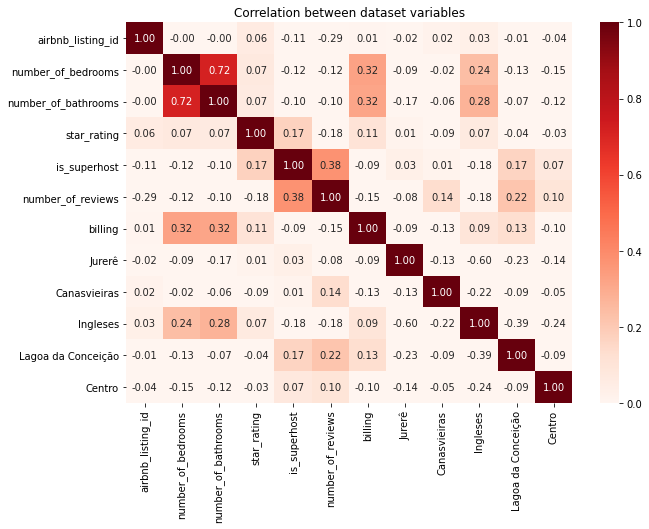

In [16]:
# Checando se há correlação positiva entre as features e o faturamento
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(df_analysis.corr(method='kendall'),
            annot = True,
            vmin=0,
            fmt = '.2f',
            cmap='Reds')
plt.title('Correlation between dataset variables')
plt.show()

### **CONCLUSÃO:** Através do gráfico de heatmap é perceptível que há sim uma correlação entre algumas das features e o faturamento. Pode-se observar que: number_of_bedrooms', 'number_of_'bathrooms' tem uma forte correlação entre si e com o faturamento, e a feature 'star_rating', junto dos bairros: Ingleses e Lagoa da Conceição apesar de possuirem uma correlação mais fraca com o faturamento, ela também é considerável. 
### Pode-se absorver também dessa análise que ao alugar através de um anúncio no airbnb, as pessoas costumam procurar por um número de quartos e banheiros equivalente, o que pode estar relacionado com um maior aluguel de suites e geralmente localizados no bairro Ingleses já que esse possue forte correlação com esses cômodos

# 4. Qual a antecedência média das reservas? Esse número é maior ou menor para finais de semana?

In [17]:
# Transformando features de data em tipo datetime para poder manipulá-las
df3_price = df2_price.copy()

df3_price['booked_on'] = pd.to_datetime(df3_price['booked_on'])
df3_price['date'] = pd.to_datetime(df3_price['date'])

# Obtendo o dia da semana, começando na segunda-feira com o índice = 0
df3_price['days'] = df3_price['date'].dt.weekday

In [18]:
# Adiantamento de reservas em dias
df4_price = df3_price
df4_price['advance_booking'] = (df3_price['date'] - df3_price['booked_on']).dt.days

In [19]:
# Removendo outliers
df5_price = df4_price[df4_price.advance_booking < 36]

Text(0.5, 1.0, 'Advance booking - After removing outliers')

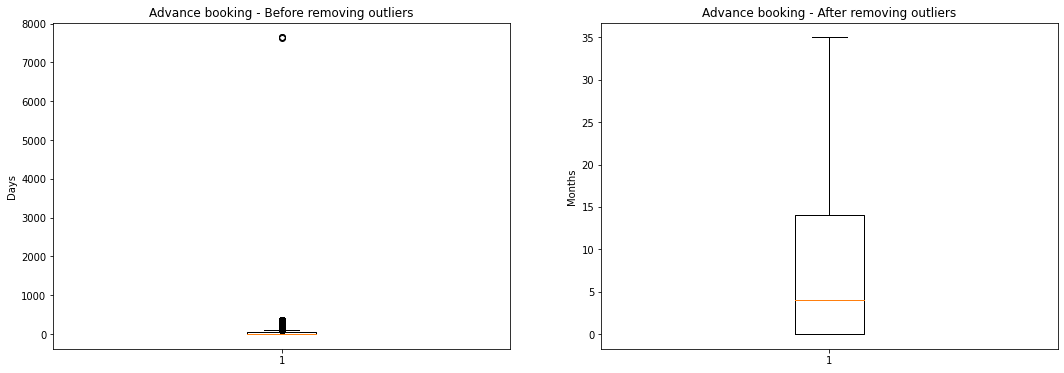

In [20]:
# Plotando gráficos para análise
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axes[0].boxplot(df4_price.advance_booking)
axes[0].set_ylabel('Days')
axes[0].set_title('Advance booking - Before removing outliers')

axes[1].boxplot(df5_price.advance_booking)
axes[1].set_ylabel('Months')
axes[1].set_title('Advance booking - After removing outliers')

In [21]:
# Média de advance_booking
df5_price['advance_booking'].mean()

8.193997537043657

In [22]:
# Média de reservas realizadas por dia da semana
df6_price = df5_price.groupby('days', as_index=False).advance_booking.mean().round(2)
df6_price = df6_price.sort_values(['days'])

Text(0.5, 1.0, 'Advance booking')

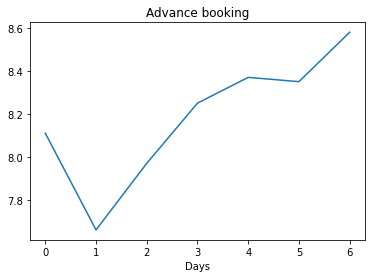

In [23]:
plt.plot(df6_price.days, df6_price.advance_booking)
plt.xlabel('Days')
plt.title('Advance booking')

## **CONCLUSÃO:** Desconsiderando os outliers, houve uma antecedência média de 8.19 dias nas reservas e esse número foi maior no final de semana

# Análise Bônus

## Para quando as propriedades foram alugadas com mais frequência

In [24]:
df7_price = df5_price.copy()
df7_price['months'] = df7_price['date'].dt.month_name()

# Checando os meses inclusos no dataset
df7_price['months'].unique()

array(['January', 'February', 'March', 'December', 'November'],
      dtype=object)

In [25]:
# Agrupando os dias e os meses por sua frequência
df_days = df7_price.groupby('days', as_index=False).days.count()
df_months = df7_price.groupby('months', as_index=False).months.count()

# Listas usadas para representar o eixo X nos gráficos
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months = ['Jan','Feb','Mar','Nov','Dec']

Text(0.5, 1.0, 'Frequency of rented ads during the year')

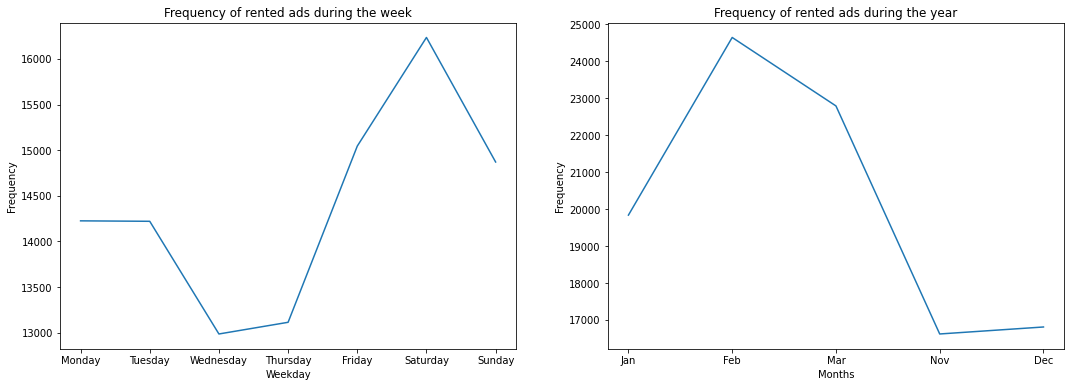

In [26]:
# Plotando gráficos para análise
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axes[0].plot(days, df_days)
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Frequency of rented ads during the week')

axes[1].plot(months, df_months)
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Frequency of rented ads during the year')

## **CONCLUSÃO:** Como pode ser visualizado nos gráficos a cima, os alugueis dos imoveis anunciados estão focados nos finais de semana e no primeiro trimestre do ano, correspondente ao verão